# Website Ranking using Keyword Extraction and PageRank Algorithm

## Importing required packages

In [ ]:
import urllib.request
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

## Creation of Dataset
- Information retrieval using web scraping
- Dataset obtained in JSON format

### Retrieval of Pages through Web Scraping

To maintain simplicity & narrow the amount of content, only the "Latest News" from the home page was used.

In [ ]:
URL = "https://en.wikinews.org/"

response = requests.get(URL)
soup = BeautifulSoup(response.content, "html.parser")

Search results:

In [ ]:
my_divs = soup.find_all('div', {'class': 'latest_news_text'})
links = []
for div in my_divs:
  link = div.find_all('a')
  links.extend(list(map(lambda l: "https://en.wikinews.org"+l.get('href'),list(link))))
  
for l in links[:5]:
  print(l)

https://en.wikinews.org/wiki/New_study_analyzes_the_varying_levels_of_protection_offered_by_COVID-19_vaccines?dpl_id=2971578
https://en.wikinews.org/wiki/Waymo_announces_expansion_of_autonomous_taxi_coverage_in_Arizona,_San_Francisco?dpl_id=2971131
https://en.wikinews.org/wiki/First_NASA_TROPICS_satellites_launch_to_monitor_tropical_storms?dpl_id=2971362
https://en.wikinews.org/wiki/Archbishop_of_Canterbury_crowns_King_Charles_III_in_the_UK?dpl_id=2969843
https://en.wikinews.org/wiki/Labour_becomes_largest_party_in_UK_local_government_after_2023_English_elections?dpl_id=2971250


In [ ]:
len(links)

16

### Finding Outbound links - Recursively

The function below returns a list of outbound links.
- Outbound links are the hyperlinks present in a webpage. They could be other articles, sharing links or links to navigate through the website.
- Sharing links are not considered since they do not lead to any particular page & they do not have outbound links.
Eg: "Share this article on Reddit"

In [ ]:
def get_outbound(link):
  article = requests.get(link)
  soup = BeautifulSoup(article.content, "html.parser")
  links = []
  for link in soup.find_all('a', href = True):
      href = link.get('href')
      if href.startswith('/wiki/') or href.startswith('/w/'):
        t = 'https://en.wikinews.org' + link['href']
        if t not in links:
          links.append(t)

  return links

The function creates the dataframe of the outbound links & URLs by recursively scraping the outbound links.

Steps:
1. Take URL input
2. Find outbound links (OL)
3. Get outbound links of each of OL
4. Add row: URL, outbound links

The number of times the function is recursively called is determined by the maximum depth provided.

In [ ]:
def build_dataframe(url, depth, max_depth, df):

  outbound_links = get_outbound(url)

  if url in df['url'].values:
    return

  df.loc[len(df)] = [url, outbound_links]

  if depth == max_depth or not outbound_links:
    return

  for i, link in enumerate(outbound_links):
    build_dataframe(link, depth+1, max_depth, df)

In [ ]:
data = pd.DataFrame(columns=['url', 'outbound_links'])

# for link in links:
initial_url = l
max_depth = 3

build_dataframe(initial_url, 0, max_depth, data)

In [ ]:
data = pd.read_json('wiki_news_6k.json')

In [ ]:
data.head()

,url,outbound_links
0,https://en.wikinews.org/wiki/First_NASA_TROPIC...,"[https://en.wikinews.org/wiki/Space, https://e..."
1,https://en.wikinews.org/wiki/Space,[https://en.wikinews.org/w/index.php?title=Spa...
2,https://en.wikinews.org/w/index.php?title=Spac...,[https://en.wikinews.org/wiki/Help:Page_valida...
3,https://en.wikinews.org/wiki/Help:Page_validation,[https://en.wikinews.org/w/index.php?title=Hel...
4,https://en.wikinews.org/wiki/Category:Space,[https://en.wikinews.org/wiki/Saudi_Arabia_ann...


### Getting Web Page Information

Below function returns the Title/Heading of a page, given the URL.

In [ ]:
def get_title(link):
  article = requests.get(link)
  soup = BeautifulSoup(article.content, "html.parser")
  return soup.find('h1').get_text()

Below function returns the content of a page (article body, in this case), given the URL.

In [ ]:
def get_content(link):
  article = requests.get(link)
  soup = BeautifulSoup(article.content, "html.parser")
  ps = soup.find_all('p')
  cont = ''
  for p in ps:
    cont += str(p)
  return cont

Below function returns the published date, given the URL.
Making sure that the articles are not outdated.

In [ ]:
def get_date(link):
  article = requests.get(link)
  soup = BeautifulSoup(article.content, "html.parser")
  try:
    date = soup.find('strong', {'class': 'published'}).get_text()
  except:
    time = datetime.now()
    date = time.strftime("%A, %B %d, %Y")
  return date

Creating new columns in the dataframe:

In [ ]:
data['title'] = data['url'].apply(get_title)

In [ ]:
data['content'] = data['url'].apply(get_content)

In [ ]:
data['date'] = data['url'].apply(get_date)

In [ ]:
data = pd.read_json('final_db_6k.json')

In [ ]:
data.head()

,url,outbound_links,title,content,date
0,https://en.wikinews.org/wiki/First_NASA_TROPIC...,"[https://en.wikinews.org/wiki/Space, https://e...",First NASA TROPICS satellites launch to monito...,"<p><strong class=""published""><span class=""valu...",2023-05-09
1,https://en.wikinews.org/wiki/Space,[https://en.wikinews.org/w/index.php?title=Spa...,Category:Space,"<p>This is the category for <b><a class=""exti...",2023-05-11
2,https://en.wikinews.org/w/index.php?title=Spac...,[https://en.wikinews.org/wiki/Help:Page_valida...,Space,<p>Redirect to:</p>,2023-05-11
3,https://en.wikinews.org/wiki/Help:Page_validation,[https://en.wikinews.org/w/index.php?title=Hel...,Wikinews:Flagged revisions,"<p><a class=""mw-redirect"" href=""/wiki/Wikinews...",2023-05-11
4,https://en.wikinews.org/wiki/Category:Space,[https://en.wikinews.org/wiki/Saudi_Arabia_ann...,Category:Space,"<p>This is the category for <b><a class=""exti...",2023-05-11


### Data Preprocessing

In [ ]:
# Removing all <HTML> Tags
def remove_tags(content):
  soup = BeautifulSoup(content, 'html.parser')
  return soup.get_text()

data['content'] = data['content'].apply(remove_tags)
print(data['content'])

0       Tuesday, May 9, 2023 \nOn Sunday at about 13:0...
1       This is the category for  space, covering anyt...
2                                            Redirect to:
3       Wikinews is currently running MediaWiki with t...
4       This is the category for  space, covering anyt...
                              ...                        
6235    Idioma: Deutsch | English | Esperanto | frança...
6236    Lingua: Deutsch | English | Esperanto | frança...
6237    Taal: Deutsch | English | Esperanto | français...
6238    You must have cookies enabled to log in to Wik...
6239    Language: Deutsch | English | Esperanto | fran...
Name: content, Length: 6240, dtype: object


In [ ]:
# Removing stop words in English
def remove_stop_words(content):
  words = word_tokenize(content)
  stop_words_dict = set(stopwords.words('english'))
  filtered_words = [word for word in words 
                    if word.lower() not in stop_words_dict]
  content = " ".join(filtered_words)
  return content

data['content'] = data['content'].apply(remove_stop_words)
print(data['content']) 

0       Tuesday , May 9 , 2023 Sunday 13:00 NZST ( 010...
1       category space , covering anything beyond Eart...
2                                              Redirect :
3       Wikinews currently running MediaWiki flagged r...
4       category space , covering anything beyond Eart...
                              ...                        
6235    Idioma : Deutsch | English | Esperanto | franç...
6236    Lingua : Deutsch | English | Esperanto | franç...
6237    Taal : Deutsch | English | Esperanto | françai...
6238    must cookies enabled log Wikinews . Language :...
6239    Language : Deutsch | English | Esperanto | fra...
Name: content, Length: 6240, dtype: object


In [ ]:
# Converting to lower case
data['content'] = data['content'].str.lower()

In [ ]:
# Removing apostrophe
data['content'] = data['content'].str.replace("'", "")

In [ ]:
# Removing punctuation
def remove_punctuation(content):
    return content.translate(str.maketrans('', '', string.punctuation))
remove_punctuation_vec = np.vectorize(remove_punctuation)
data['content'] = data['content'].apply(remove_punctuation_vec)

In [ ]:
# Removing numbers
data['content'] = data['content'].str.replace('\d+', '')

# Removing extra whitespaces
data['content'] = data['content'].str.replace(r'\s+', ' ', regex=True).str.strip()

<ipython-input-18-7f1a277b8cc3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['content'] = data['content'].str.replace('\d+', '')


In [ ]:
print(data['content']) 

0       tuesday may sunday nzst utc rocket lab electro...
1       category space covering anything beyond earth ...
2                                                redirect
3       wikinews currently running mediawiki flagged r...
4       category space covering anything beyond earth ...
                              ...                        
6235    idioma deutsch english esperanto français espa...
6236    lingua deutsch english esperanto français espa...
6237    taal deutsch english esperanto français españo...
6238    must cookies enabled log wikinews language deu...
6239    language deutsch english esperanto français es...
Name: content, Length: 6240, dtype: object


### Calculating Tf/Idf scores

In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TfidfVectorizer object
vectorizer = TfidfVectorizer()
vectorizer.fit(data['content'])
tfidf_matrix = vectorizer.transform(data['content'])

# convert the matrix to a dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# find the index of top 20 words with the highest tf-idf score for each document
top_20_words_idx = tfidf_df.apply(lambda x: x.argsort()[-20:][::-1], axis=1)

# get the words with the top 20 tf-idf scores for each row
top_20_words = top_20_words_idx.apply(lambda x: [vectorizer.get_feature_names_out()[i] for i in x])

words_list = top_20_words.apply(lambda x: x.tolist(), axis=1)

data['keywords_dict'] = words_list

In [ ]:
# Adding article_id column to df
data['article_id'] = data.reset_index().index
data = data[["article_id", "title", "url", "date", "content", "outbound_links", "keywords_dict"]]

In [ ]:
data.head()

,article_id,title,url,date,content,outbound_links,keywords_dict
0,0,First NASA TROPICS satellites launch to monito...,https://en.wikinews.org/wiki/First_NASA_TROPIC...,2023-05-09,tuesday may sunday nzst utc rocket lab electro...,"[https://en.wikinews.org/wiki/Space, https://e...","[rocket, tropics, observations, hurricane, sat..."
1,1,Category:Space,https://en.wikinews.org/wiki/Space,2023-05-11,category space covering anything beyond earth ...,[https://en.wikinews.org/w/index.php?title=Spa...,"[category, spaceports, groundbased, observator..."
2,2,Space,https://en.wikinews.org/w/index.php?title=Spac...,2023-05-11,redirect,[https://en.wikinews.org/wiki/Help:Page_valida...,"[redirect, 한국어, forensic, forecasts, foreclose..."
3,3,Wikinews:Flagged revisions,https://en.wikinews.org/wiki/Help:Page_validation,2023-05-11,wikinews currently running mediawiki flagged r...,[https://en.wikinews.org/w/index.php?title=Hel...,"[sighting, flagged, peer, revisions, default, ..."
4,4,Category:Space,https://en.wikinews.org/wiki/Category:Space,2023-05-11,category space covering anything beyond earth ...,[https://en.wikinews.org/wiki/Saudi_Arabia_ann...,"[category, spaceports, groundbased, observator..."


In [ ]:
data['keywords_dict'] = data['keywords_dict'].apply(lambda x: ', '.join(x))

#Inserting the webpages data to DB 

In [ ]:
article_df = data[["article_id","title","url","date","outbound_links"]]
content_df = data[["article_id","content","keywords_dict"]]

In [ ]:
article_df.head()

,article_id,title,url,date,outbound_links
0,0,First NASA TROPICS satellites launch to monito...,https://en.wikinews.org/wiki/First_NASA_TROPIC...,2023-05-09,"[https://en.wikinews.org/wiki/Space, https://e..."
1,1,Category:Space,https://en.wikinews.org/wiki/Space,2023-05-11,[https://en.wikinews.org/w/index.php?title=Spa...
2,2,Space,https://en.wikinews.org/w/index.php?title=Spac...,2023-05-11,[https://en.wikinews.org/wiki/Help:Page_valida...
3,3,Wikinews:Flagged revisions,https://en.wikinews.org/wiki/Help:Page_validation,2023-05-11,[https://en.wikinews.org/w/index.php?title=Hel...
4,4,Category:Space,https://en.wikinews.org/wiki/Category:Space,2023-05-11,[https://en.wikinews.org/wiki/Saudi_Arabia_ann...


In [ ]:
content_df.head()

,article_id,content,keywords_dict
0,0,tuesday may sunday nzst utc rocket lab electro...,"rocket, tropics, observations, hurricane, sate..."
1,1,category space covering anything beyond earth ...,"category, spaceports, groundbased, observatori..."
2,2,redirect,"redirect, 한국어, forensic, forecasts, foreclose,..."
3,3,wikinews currently running mediawiki flagged r...,"sighting, flagged, peer, revisions, default, d..."
4,4,category space covering anything beyond earth ...,"category, spaceports, groundbased, observatori..."


In [ ]:
article_df.to_json('article.json', orient='records')

In [ ]:
content_df.to_json('content.json', orient='records')

Connecting to MongoDB instance

In [ ]:
!pip install pymongo


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pymongo

client = pymongo.MongoClient('mongodb://127.0.0.1:27017/', connectTimeoutMS=30000)
db = client.dbsp

article_table = db['article'] 
content_table = db['content']

In [ ]:
article_docs = article_df.to_dict(orient='records')
content_docs = content_df.to_dict(orient='records')

article_table.insert_many(article_docs)
content_table.insert_many(content_docs)

In [ ]:
article_docs = article_df.to_dict(orient='records')
content_docs = content_df.to_dict(orient='records')

article_table.insert_many(article_docs)
content_table.insert_many(content_docs)

Finding URLs mapped to search term as per Tf/Idf score

Query that was executed on MongoDB: 

`db.article.aggregate( [ {$match : {title: {$regex: "US",$options:"i"}}}, { $lookup: { from: "content", localField: "article_id", foreignField: "article_id", as: "content" }  } ,{$match : {"content.keywords_dict": {$regex: "US",$options:"i"}}} ,  { $project: {article_id:1, outbound_links:1}}] `

In [ ]:
search = input("Enter the keyword to be searched: ")

Enter the keyword to be searched: usa


In [ ]:
results = db.article.aggregate([{"$match" : {"title": {"$regex": search ,"$options":"i"}}},
                                {"$lookup": {"from": "content","localField": "article_id", "foreignField": "article_id", "as": "content"}},
                                {"$match" : {"content.keywords_dict":{"$regex": search,"$options":"i"}}},
                                {"$project": {"article_id":1, "outbound_links":1}}])

# Process the results
for doc in results:
    print(doc)

{'_id': ObjectId('645d60fd7efa6e38cc4f9550'), 'article_id': 1434, 'outbound_links': ['https://en.wikinews.org/w/index.php?title=USA_Today&redirect=no', 'https://en.wikinews.org/wiki/Virginia', 'https://en.wikinews.org/wiki/On_the_campaign_trail_in_the_USA,_September_2016', 'https://en.wikinews.org/wiki/Facebook_hired_PR_firm_to_discredit_Google,_reveals_leaked_correspondence', 'https://en.wikinews.org/wiki/Obama_approval_ratings_hit_new_lows', 'https://en.wikinews.org/wiki/%22Anonymous%22_releases_statements_outlining_%22War_on_Scientology%22', 'https://en.wikinews.org/wiki/British_top_General_says_troops_are_unwelcome_in_Iraq', 'https://en.wikinews.org/wiki/Verizon_says_customer_phone_records_were_not_handed_over_to_the_NSA', 'https://en.wikinews.org/wiki/BellSouth_denies_phone_records_were_handed_over_to_the_NSA', 'https://en.wikinews.org/wiki/USA_Today_reports_NSA_obtained_call_logs_from_communications_companies', 'https://en.wikinews.org/wiki/Polling_data_on_President_Bush%27s_appr

## PageRank

To calculate the rank of a page, a **directed graph** must be created to identify the inbound links of all pages.
- The rank is dependent on the ranks of the pages that link to it and the number of outbound links of those pages.
- Rank is recursively calculated as and when new nodes are added.

In [ ]:
graph = nx.DiGraph()
graph.add_nodes_from(df['url'])

# checking for edges (URL -> URL)
for _, row in df.iterrows():
    url = row['url']
    outbound_links = row['outbound_links']
    
    # Add edges from the current URL to its outbound links
    for link in outbound_links:
        graph.add_edge(url, link)

Calculating the page rank:

In [ ]:
pagerank = nx.pagerank(graph)

Following are the Top 5 ranked pages in the given dataset:

In [ ]:
df_pagerank = pd.DataFrame({'url': list(pagerank.keys()), 'pagerank': list(pagerank.values())})
df_pagerank = df_pagerank.sort_values(by='pagerank', ascending=False)

df_pagerank.head()

,url,pagerank
278,https://en.wikinews.org/wiki/Category:Oceania,0.000463
272,https://en.wikinews.org/wiki/Category:Antarctica,0.000463
270,https://en.wikinews.org/wiki/Wikinews:Contact_us,0.000463
279,https://en.wikinews.org/wiki/Category:South_Am...,0.000463
289,https://en.wikinews.org/wiki/Wikinews:General_...,0.000463


### Visualization

Visualizing a nodes and edges
- The chosen depth to find outbound links was 2
- Only top N (N=10) are visualized

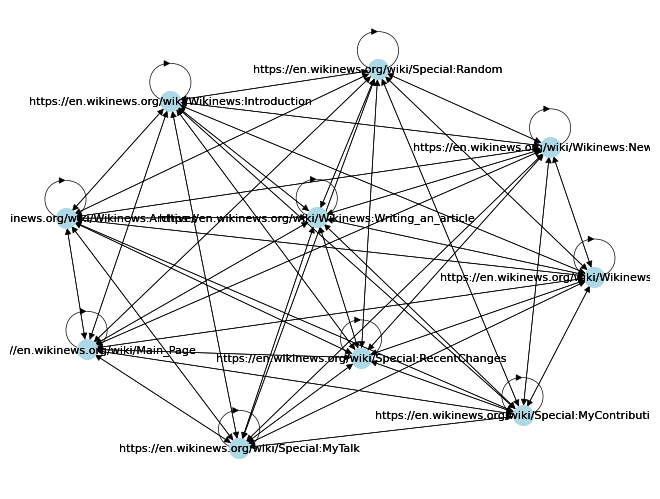

In [ ]:
top_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:10]

subgraph = graph.subgraph(top_nodes)

pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=200, font_size=8, node_color='lightblue', width=0.5)

node_labels = {node: node for node in top_nodes}
nx.draw_networkx_labels(subgraph, pos, labels=node_labels, font_size=8)

plt.show()

- The chosen depth to find outbound links was 1
- Nodes are not in any particular order. First N (N=20) nodes are visualized)

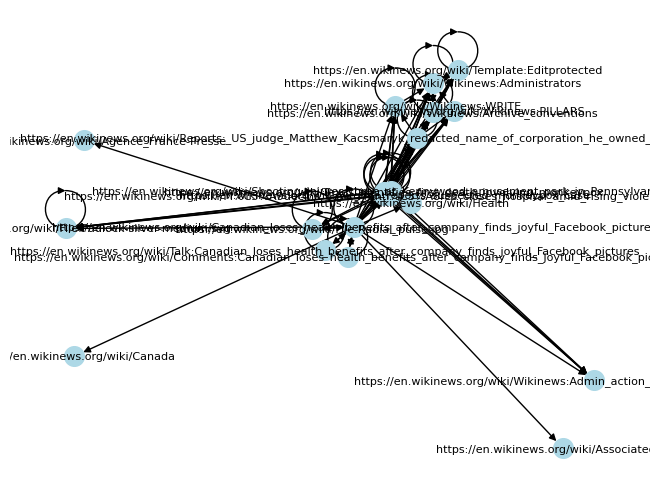

In [ ]:
G = nx.DiGraph()  # Directed graph

for index, row in df.iterrows():
    # Add nodes (pages) to the graph
    G.add_node(row['url'], title=row['title'], content=row['content'], date=row['date'])
    
    # Split the outbound links string and add edges (connections)
    outbound_links = row['outbound_links']
    for link in outbound_links:
        G.add_edge(row['url'], link)

# Subset of nodes to print (first three nodes)
nodes_to_print = list(G.nodes())[:20]

# Create a subgraph with the desired nodes
subgraph = G.subgraph(nodes_to_print)

# Visualize the subgraph
nx.draw(subgraph, with_labels=True, node_size=200, node_color='lightblue', font_size=8)
plt.show()

In [ ]:
!pip freeze > requirements.txt